Common to all plots: 

In [22]:
import sys
sys.path.insert(0, '..')
import argparse

import os
import random
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [99]:
def calculate_mean_std(df, columns):
    series_list = []
    for column_name in columns:
        series_list.append(df[column_name])

    numpy_arr = np.array(series_list).T
    mean_arr = np.mean(numpy_arr, axis=1)
    std_arr = np.std(numpy_arr, axis=1)
    return mean_arr, std_arr

def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'same') / n

def numpy_ewma_vectorized(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


def error_fill(x, y, y_error, color=None, alpha_fill=0.3, ax=None, fontsize=20, x_lab=r'$\epsilon$ rate',y_lab='Reward', plot_label=''):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(y_error) or len(y_error) == len(y):
        y_min = y - y_error/1.5
        y_max = y + y_error/1.5
    elif len(y_error) == 2:
        y_min, y_max = y_error
    else:
        y_min = y_max = 0
    ax.plot(x, y, color=color, label=plot_label)
    ax.fill_between(x, y_max, y_min, color=color, alpha=alpha_fill)
    ax.set_xlim(np.min(x),np.max(x))
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_ylabel(y_lab, fontsize=fontsize)
    ax.set_xlabel(x_lab, fontsize=fontsize)
    ax.grid(True)
    ax.legend(fontsize=fontsize, loc='best')

In [100]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

Evaluation plot

In [101]:
# file_csv_name_r2 = "evaluation_r2.csv" # 'wandb_export_2022-12-20_time.csv' # 'wandb_export_2022-12-18.csv'
r2_eval = pd.read_csv('evaluation_r2.csv')
vanilla_eval = pd.read_csv('evaluation_vanilla.csv')
robust_eval = pd.read_csv('evaluation_robust.csv')

In [96]:
# r2_eval['value_param']

<Figure size 432x288 with 0 Axes>

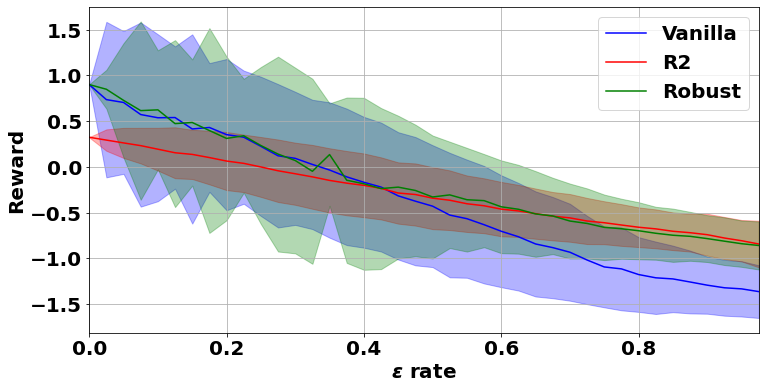

In [102]:
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20
window = 5

error_fill(vanilla_eval['value_param'], vanilla_eval['avg'], vanilla_eval['std'],'b',plot_label='Vanilla')
error_fill(r2_eval['value_param'], r2_eval['avg'], r2_eval['std'],'r', plot_label='R2')
error_fill(robust_eval['value_param'], robust_eval['avg'], robust_eval['std'],'g', plot_label='Robust')

# ax.plot(np.array(vanilla_eval['value_param']), vanilla_eval['avg'],'b', label='Vanilla') 
# ax.fill_between(np.array(vanilla_eval['value_param']), vanilla_eval['std'],'b', label='Vanilla') 

# ax.plot(r2_eval['value_param'], r2_eval['avg'],'r', label='R2') 
# ax.fill_between(r2_eval['value_param'], r2_eval['std'], alpha=0.15)

# ax.plot(step, robust_cp_rew_smooth,'g', label='Robust')
# ax.fill_between(step, robust_cp_min_smooth, robust_cp_max_smooth, alpha=0.15)

    
# # ax.invert_xaxis()
# ax.set_xlabel(r'$\epsilon$ rate', fontsize=fontsize)
# ax.set_ylabel('Reward', fontsize=fontsize)
# # ax.set_title('Mars Rover Environment Reward', fontweight="bold", fontsize=fontsize)
# # ax.set_xlim(np.min(step),np.max(step))
# # ax.set_xticks(range(0,580,100))
# # ax.set_yticks(range(-10,1,2))
# # ax.set_ylim(-12,1.5)
# ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# ax.tick_params(axis='both', labelsize=fontsize)
# ax.xaxis.get_offset_text().set_fontsize(fontsize)

# # plt.axvline(x=0.001, c='black')

# ax.grid(True)
# ax.legend(fontsize=fontsize, loc='best')

plt.savefig(os.path.abspath('evaluation_rover.png'))

Plot specific: beta values on rover

In [18]:
file_csv_name = "norm_dsitance_beta.csv" # 'wandb_export_2022-12-20_time.csv' # 'wandb_export_2022-12-18.csv'
rover_convergence_raw = pd.read_csv(file_csv_name)

In [33]:
# r2_cv_ind = 600 # 8070 # 75000 # 165000 # 155573
# rover_convergence_raw.iloc[:r2_cv_ind,:] 
# rover_convergence_raw = rover_convergence_raw.iloc[:r2_cv_ind,:] 

In [19]:
rover_convergence_raw

,Step,beta: 1 - r2_norm_distance,beta: 1 - r2_norm_distance__MIN,beta: 1 - r2_norm_distance__MAX,beta: 0.1 - r2_norm_distance,beta: 0.1 - r2_norm_distance__MIN,beta: 0.1 - r2_norm_distance__MAX,beta: 0.0001 - r2_norm_distance,beta: 0.0001 - r2_norm_distance__MIN,beta: 0.0001 - r2_norm_distance__MAX,beta: 0.00001 - r2_norm_distance,beta: 0.00001 - r2_norm_distance__MIN,beta: 0.00001 - r2_norm_distance__MAX,beta: 1e-7 - r2_norm_distance,beta: 1e-7 - r2_norm_distance__MIN,beta: 1e-7 - r2_norm_distance__MAX
0,0,3.989628,3.989628,3.989628,3.988179,3.988179,3.988179,3.719951,3.719951,3.719951,4.093296,4.093296,4.093296,NaN,NaN,NaN
1,1,3.719953,3.719953,3.719953,3.715308,3.715308,3.715308,3.719944,3.719944,3.719944,4.093296,4.093296,4.093296,NaN,NaN,NaN
2,2,4.003917,3.914539,4.093296,3.910484,3.910484,3.910484,3.934266,3.719933,4.093292,3.863165,3.719951,3.989622,4.093296,4.093296,4.093296
3,3,3.879936,3.879936,3.879936,3.889738,3.710879,4.080764,NaN,NaN,NaN,4.003915,3.914537,4.093294,3.914539,3.914539,3.914539
4,4,NaN,NaN,NaN,3.861251,3.861251,3.861251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51584,52332,NaN,NaN,NaN,0.972820,0.972820,0.972820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51585,52335,NaN,NaN,NaN,1.000130,1.000130,1.000130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51586,52336,NaN,NaN,NaN,0.826628,0.826628,0.826628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51587,52339,NaN,NaN,NaN,0.898242,0.898242,0.898242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
list(rover_convergence_raw.columns)

['Step',
 'beta: 1 - r2_norm_distance',
 'beta: 1 - r2_norm_distance__MIN',
 'beta: 1 - r2_norm_distance__MAX',
 'beta: 0.1 - r2_norm_distance',
 'beta: 0.1 - r2_norm_distance__MIN',
 'beta: 0.1 - r2_norm_distance__MAX',
 'beta: 0.0001 - r2_norm_distance',
 'beta: 0.0001 - r2_norm_distance__MIN',
 'beta: 0.0001 - r2_norm_distance__MAX',
 'beta: 0.00001 - r2_norm_distance',
 'beta: 0.00001 - r2_norm_distance__MIN',
 'beta: 0.00001 - r2_norm_distance__MAX',
 'beta: 1e-7 - r2_norm_distance',
 'beta: 1e-7 - r2_norm_distance__MIN',
 'beta: 1e-7 - r2_norm_distance__MAX']

In [21]:
# step = rover_convergence_raw['Step']

# beta_1_ind = rover_convergence_raw[rover_convergence_raw['beta: 1 - reward'].notnull()].index.tolist()

# beta_1 = rover_convergence_raw.iloc[beta_1_ind,:]['beta: 1 - reward']
# beta_1_min = rover_convergence_raw.iloc[beta_1_ind,:]['beta: 1 - reward__MIN']
# beta_1_max = rover_convergence_raw.iloc[beta_1_ind,:]['beta: 1 - reward__MAX']


# beta_01_ind = rover_convergence_raw[rover_convergence_raw['beta: 0.1 - reward'].notnull()].index.tolist()

# beta_01 = rover_convergence_raw.iloc[beta_01_ind,:]['beta: 0.1 - reward']
# beta_01_min = rover_convergence_raw.iloc[beta_01_ind,:]['beta: 0.1 - reward__MIN']
# beta_01_max = rover_convergence_raw.iloc[beta_01_ind,:]['beta: 0.1 - reward__MAX']



# beta_001_ind = rover_convergence_raw[rover_convergence_raw['beta: 0.0001 - reward'].notnull()].index.tolist()

# beta_001 = rover_convergence_raw.iloc[beta_001_ind,:]['beta: 0.0001 - reward']
# beta_001_min = rover_convergence_raw.iloc[beta_001_ind,:]['beta: 0.0001 - reward__MIN']
# beta_001_max = rover_convergence_raw.iloc[beta_001_ind,:]['beta: 0.0001 - reward__MAX']


# beta_0001_ind = rover_convergence_raw[rover_convergence_raw['beta: 0.00001 - reward'].notnull()].index.tolist()

# beta_0001 = rover_convergence_raw.iloc[beta_0001_ind,:]['beta: 0.00001 - reward']
# beta_0001_min = rover_convergence_raw.iloc[beta_0001_ind,:]['beta: 0.00001 - reward__MIN']
# beta_0001_max = rover_convergence_raw.iloc[beta_0001_ind,:]['beta: 0.00001 - reward__MAX']

# beta_701_ind = rover_convergence_raw[rover_convergence_raw['beta: 1e-7 - reward'].notnull()].index.tolist()

# beta_701 = rover_convergence_raw.iloc[beta_701_ind,:]['beta: 1e-7 - reward']
# beta_701_min = rover_convergence_raw.iloc[beta_701_ind,:]['beta: 1e-7 - reward__MIN']
# beta_701_max = rover_convergence_raw.iloc[beta_701_ind,:]['beta: 1e-7 - reward__MAX']





step = rover_convergence_raw['Step']

beta_1_ind = rover_convergence_raw[rover_convergence_raw['beta: 1 - r2_norm_distance'].notnull()].index.tolist()

beta_1 = rover_convergence_raw.iloc[beta_1_ind,:]['beta: 1 - r2_norm_distance']
beta_1_min = rover_convergence_raw.iloc[beta_1_ind,:]['beta: 1 - r2_norm_distance__MIN']
beta_1_max = rover_convergence_raw.iloc[beta_1_ind,:]['beta: 1 - r2_norm_distance__MAX']


beta_01_ind = rover_convergence_raw[rover_convergence_raw['beta: 0.1 - r2_norm_distance'].notnull()].index.tolist()

beta_01 = rover_convergence_raw.iloc[beta_01_ind,:]['beta: 0.1 - r2_norm_distance']
beta_01_min = rover_convergence_raw.iloc[beta_01_ind,:]['beta: 0.1 - r2_norm_distance__MIN']
beta_01_max = rover_convergence_raw.iloc[beta_01_ind,:]['beta: 0.1 - r2_norm_distance__MAX']



beta_001_ind = rover_convergence_raw[rover_convergence_raw['beta: 0.0001 - r2_norm_distance'].notnull()].index.tolist()

beta_001 = rover_convergence_raw.iloc[beta_001_ind,:]['beta: 0.0001 - r2_norm_distance']
beta_001_min = rover_convergence_raw.iloc[beta_001_ind,:]['beta: 0.0001 - r2_norm_distance__MIN']
beta_001_max = rover_convergence_raw.iloc[beta_001_ind,:]['beta: 0.0001 - r2_norm_distance__MAX']


beta_0001_ind = rover_convergence_raw[rover_convergence_raw['beta: 0.00001 - r2_norm_distance'].notnull()].index.tolist()

beta_0001 = rover_convergence_raw.iloc[beta_0001_ind,:]['beta: 0.00001 - r2_norm_distance']
beta_0001_min = rover_convergence_raw.iloc[beta_0001_ind,:]['beta: 0.00001 - r2_norm_distance__MIN']
beta_0001_max = rover_convergence_raw.iloc[beta_0001_ind,:]['beta: 0.00001 - r2_norm_distance__MAX']

beta_701_ind = rover_convergence_raw[rover_convergence_raw['beta: 1e-7 - r2_norm_distance'].notnull()].index.tolist()

beta_701 = rover_convergence_raw.iloc[beta_701_ind,:]['beta: 1e-7 - r2_norm_distance']
beta_701_min = rover_convergence_raw.iloc[beta_701_ind,:]['beta: 1e-7 - r2_norm_distance__MIN']
beta_701_max = rover_convergence_raw.iloc[beta_701_ind,:]['beta: 1e-7 - r2_norm_distance__MAX']


<ipython-input-16-4aa38ddbf03c>:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
<ipython-input-16-4aa38ddbf03c>:58: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

<Figure size 432x288 with 0 Axes>

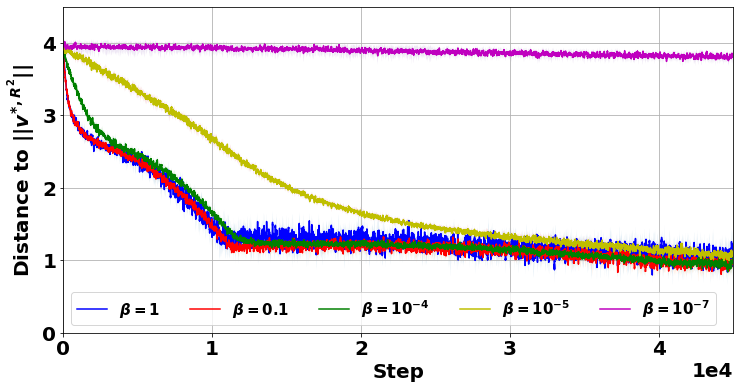

In [28]:
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20
window = 51
order = 3

beta_1_smooth = savitzky_golay(beta_1.values, window, order)
beta_1_min_smooth = savitzky_golay(beta_1_min.values, window, order)
beta_1_max_smooth = savitzky_golay(beta_1_max.values, window, order)

beta_01_smooth = savitzky_golay(beta_01.values, window, order)
beta_01_min_smooth = savitzky_golay(beta_01_min.values, window, order)
beta_01_max_smooth = savitzky_golay(beta_01_max.values, window, order)

beta_001_smooth = savitzky_golay(beta_001.values,window, order)
beta_001_min_smooth = savitzky_golay(beta_001_min.values, window, order)
beta_001_max_smooth = savitzky_golay(beta_001_max.values, window, order)

beta_0001_smooth = savitzky_golay(beta_0001.values, window, order)
beta_0001_min_smooth = savitzky_golay(beta_0001_min.values, window, order)
beta_0001_max_smooth = savitzky_golay(beta_0001_max.values, window, order)

beta_701_smooth = savitzky_golay(beta_701.values, window, order)
beta_701_min_smooth = savitzky_golay(beta_701_min.values,window, order)
beta_701_max_smooth = savitzky_golay(beta_701_max.values, window, order)

ax.plot(beta_1_ind, beta_1_smooth,'b', label=r'$\beta=1$') 
ax.fill_between(beta_1_ind, beta_1_min_smooth, beta_1_max_smooth, alpha=0.15)

ax.plot(beta_01_ind, beta_01_smooth,'r', label=r'$\beta=0.1$') 
ax.fill_between(beta_01_ind, beta_01_min_smooth, beta_01_max_smooth, alpha=0.15)

ax.plot(beta_001_ind, beta_001_smooth,'g', label=r'$\beta=10^{-4}$') 
ax.fill_between(beta_001_ind, beta_001_min_smooth, beta_001_max_smooth, alpha=0.15)

ax.plot(beta_0001_ind, beta_0001_smooth,'y', label=r'$\beta=10^{-5}$') 
ax.fill_between(beta_0001_ind, beta_0001_min_smooth, beta_0001_max_smooth, alpha=0.15)

ax.plot(beta_701_ind, beta_701_smooth,'m', label=r'$\beta=10^{-7}$') 
ax.fill_between(beta_701_ind, beta_701_min_smooth, beta_701_max_smooth, alpha=0.15)
    
# ax.invert_xaxis()
ax.set_xlabel('Step', fontsize=fontsize)
# ax.set_ylabel('Reward', fontsize=fontsize)
ax.set_ylabel(r'Distance to $||v^{*,{R}^2}||$', fontsize=fontsize)
# ax.set_title('Mars Rover Environment Reward', fontweight="bold", fontsize=fontsize)
ax.set_xlim(np.min(step),45000)
ax.set_xticks(range(0,50000,10000))
# ax.set_yticks([-1, -.5,0, .5, 1])
ax.set_yticks(range(0,5,1))
# ax.set_ylim(-1, 1.1)
ax.set_ylim(0, 4.5)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.tick_params(axis='both', labelsize=fontsize)
ax.xaxis.get_offset_text().set_fontsize(fontsize)
# plt.axvline(x=0.001, c='black')

ax.grid(True)
ax.legend(fontsize=15, loc='lower left', ncol=5)

plt.savefig(os.path.abspath('betas_dist.png'))

In [44]:
vanilla_cp_rew_not_nan = vanilla_cp_rew.values[np.invert(np.isnan(vanilla_cp_rew.values))]
vanilla_cp_min_not_nan = vanilla_cp_min.values[np.invert(np.isnan(vanilla_cp_min.values))]
vanilla_cp_max_not_nan = vanilla_cp_max.values[np.invert(np.isnan(vanilla_cp_max.values))]
vanilla_time_steps = step.values[np.invert(np.isnan(vanilla_cp_max.values))]


robust_cp_rew_not_nan = robust_cp_rew.values[np.invert(np.isnan(robust_cp_rew.values))]
robust_cp_min_not_nan = robust_cp_min.values[np.invert(np.isnan(robust_cp_min.values))]
robust_cp_max_not_nan = robust_cp_max.values[np.invert(np.isnan(robust_cp_max.values))]
robust_time_steps = step.values[np.invert(np.isnan(robust_cp_max.values))]


r2_cp_rew_not_nan = r2_cp_rew.values[np.invert(np.isnan(r2_cp_rew.values))]
r2_cp_min_not_nan = r2_cp_min.values[np.invert(np.isnan(r2_cp_min.values))]
r2_cp_max_not_nan = r2_cp_max.values[np.invert(np.isnan(r2_cp_max.values))]
r2_time_steps = step.values[np.invert(np.isnan(r2_cp_max.values))]

In [45]:
print(len(vanilla_time_steps), len(r2_time_steps), len(robust_time_steps))

35869 38986 183


In [46]:
prop = 100
cond_ind_vanilla = np.where(np.array(range(len(vanilla_time_steps)))%prop==0)[0]
cond_ind_r2 = np.where(np.array(range(len(r2_time_steps)))%prop==0)[0]
cond_ind_robust = np.where(np.array(range(len(robust_time_steps)))%1==0)[0]

vanilla_cp_rew_not_nan_ = vanilla_cp_rew_not_nan[cond_ind_vanilla]
vanilla_cp_min_not_nan_ = vanilla_cp_min_not_nan[cond_ind_vanilla]
vanilla_cp_max_not_nan_ = vanilla_cp_max_not_nan[cond_ind_vanilla]
vanilla_time_steps_ = vanilla_time_steps[cond_ind_vanilla]

r2_cp_rew_not_nan_ = r2_cp_rew_not_nan[cond_ind_r2]
r2_cp_min_not_nan_ = r2_cp_min_not_nan[cond_ind_r2]
r2_cp_max_not_nan_ = r2_cp_max_not_nan[cond_ind_r2]
r2_time_steps_ = r2_time_steps[cond_ind_r2]

robust_cp_rew_not_nan_ = robust_cp_rew_not_nan[cond_ind_robust]
robust_cp_min_not_nan_ = robust_cp_min_not_nan[cond_ind_robust]
robust_cp_max_not_nan_ = robust_cp_max_not_nan[cond_ind_robust]
robust_time_steps_ = robust_time_steps[cond_ind_robust]

<Figure size 432x288 with 0 Axes>

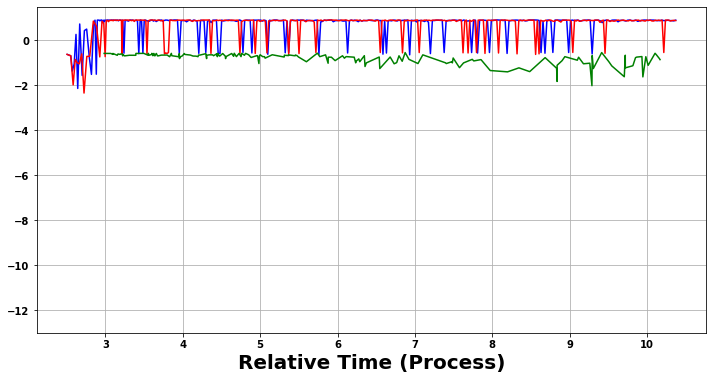

In [48]:
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20
window = 1

# vanilla_cp_rew_smooth = moving_average(vanilla_cp_rew.values, n=window)
# vanilla_cp_min_smooth = moving_average(vanilla_cp_min.values, n=window)
# vanilla_cp_max_smooth = moving_average(vanilla_cp_max.values, n=window)

# r2_cp_rew_smooth = moving_average(r2_cp_rew.values, n=window)
# r2_cp_min_smooth = moving_average(r2_cp_min.values, n=window)
# r2_cp_max_smooth = moving_average(r2_cp_max.values, n=window)

# robust_cp_rew_smooth = moving_average(robust_cp_rew.values, n=window)
# robust_cp_min_smooth = moving_average(robust_cp_min.values, n=window)
# robust_cp_max_smooth = moving_average(robust_cp_max.values, n=window)


ax.plot(vanilla_time_steps_, vanilla_cp_rew_not_nan_,'b', label='Vanilla') 
# ax.fill_between(vanilla_time_steps, vanilla_cp_min_not_nan, vanilla_cp_max_not_nan, alpha=0.15)

ax.plot(r2_time_steps_, r2_cp_rew_not_nan_,'r', label='R2') 
# ax.fill_between(r2_time_steps, r2_cp_min_not_nan, r2_cp_max_not_nan, alpha=0.15)

ax.plot(robust_time_steps_, robust_cp_rew_not_nan_,'g', label='Robust') 
# ax.fill_between(robust_time_steps, robust_cp_min_not_nan, robust_cp_max_not_nan, alpha=0.15)

# ax.plot(step, r2_cp_rew_smooth,'r', label='R2') 
# ax.fill_between(step, r2_cp_min_smooth, r2_cp_max_smooth, alpha=0.15)

# ax.plot(step, robust_cp_rew_smooth,'g', label='Robust')
# ax.fill_between(step, robust_cp_min_smooth, robust_cp_max_smooth, alpha=0.15)

    
# ax.invert_xaxis()
ax.set_xlabel('Relative Time (Process)', fontsize=fontsize)
# ax.set_ylabel('Reward', fontsize=fontsize)
# ax.set_title('Mars Rover Environment Reward', fontweight="bold", fontsize=fontsize)
# ax.set_xlim(np.min(step),np.max(step))
ax.set_yticks(range(-12,1,2))
ax.set_ylim(-13,1.5)
# ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# plt.axvline(x=0.001, c='black')

ax.grid(True)
# ax.legend(fontsize=fontsize, loc='best')

plt.savefig(os.path.abspath('wandbfixed_rover_convergence_time_zi.png'))

Convergence plot

In [8]:
file_csv_name = 'wandb_export_2022-12-15_rover.csv' # 'wandb_export_2022-12-20_time.csv' # 'wandb_export_2022-12-18.csv'
rover_convergence_raw = pd.read_csv(file_csv_name)

In [9]:
list(rover_convergence_raw.columns)

['Step',
 'algo_type: robust - reward',
 'algo_type: robust - reward__MIN',
 'algo_type: robust - reward__MAX',
 'algo_type: vanilla - reward',
 'algo_type: vanilla - reward__MIN',
 'algo_type: vanilla - reward__MAX',
 'algo_type: r2 - reward',
 'algo_type: r2 - reward__MIN',
 'algo_type: r2 - reward__MAX']

In [10]:
# rover_convergence_raw['algo_type: robust - _step'].isnull()
# list(rover_convergence_raw['algo_type: robust - _step'][rover_convergence_raw['algo_type: robust - _step'].notnull()])

In [11]:
r2_cv_ind = 600 # 8070 # 75000 # 165000 # 155573
# rover_convergence_raw.iloc[:r2_cv_ind,:] 
rover_convergence_raw = rover_convergence_raw.iloc[:r2_cv_ind,:] 

In [12]:
vanilla_cp_columns = rover_convergence_raw.filter(regex='vanilla')
robust_cp_columns = rover_convergence_raw.filter(regex='robust')
r2_cp_columns = rover_convergence_raw.filter(regex='r2')

In [13]:
# step = rover_convergence_raw['Relative Time (Process)']
step = rover_convergence_raw['Step']
vanilla_cp_rew = vanilla_cp_columns['algo_type: vanilla - reward']
vanilla_cp_min = vanilla_cp_columns['algo_type: vanilla - reward__MIN']
vanilla_cp_max = vanilla_cp_columns['algo_type: vanilla - reward__MAX']

robust_cp_rew = robust_cp_columns['algo_type: robust - reward']
robust_cp_min = robust_cp_columns['algo_type: robust - reward__MIN']
robust_cp_max = robust_cp_columns['algo_type: robust - reward__MAX']

r2_cp_rew = r2_cp_columns['algo_type: r2 - reward']
r2_cp_min = r2_cp_columns['algo_type: r2 - reward__MIN']
r2_cp_max = r2_cp_columns['algo_type: r2 - reward__MAX']
#########################################################################

<Figure size 432x288 with 0 Axes>

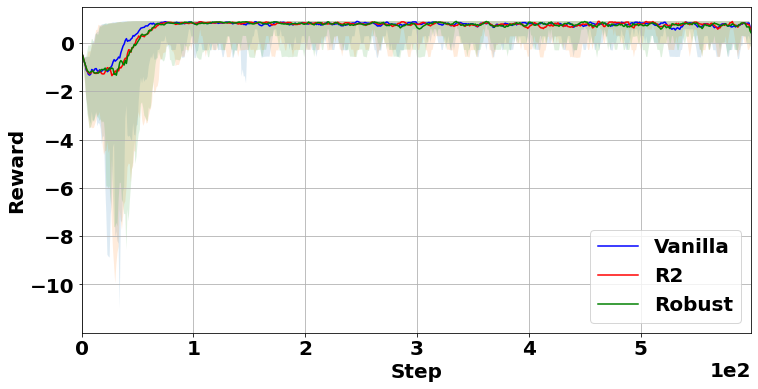

In [14]:
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20
window = 5

vanilla_cp_rew_smooth = moving_average(vanilla_cp_rew.values, n=window)
vanilla_cp_min_smooth = moving_average(vanilla_cp_min.values, n=window)
vanilla_cp_max_smooth = moving_average(vanilla_cp_max.values, n=window)

r2_cp_rew_smooth = moving_average(r2_cp_rew.values, n=window)
r2_cp_min_smooth = moving_average(r2_cp_min.values, n=window)
r2_cp_max_smooth = moving_average(r2_cp_max.values, n=window)

robust_cp_rew_smooth = moving_average(robust_cp_rew.values, n=window)
robust_cp_min_smooth = moving_average(robust_cp_min.values, n=window)
robust_cp_max_smooth = moving_average(robust_cp_max.values, n=window)

ax.plot(step, vanilla_cp_rew_smooth,'b', label='Vanilla') 
ax.fill_between(step, vanilla_cp_min_smooth, vanilla_cp_max_smooth, alpha=0.15)

ax.plot(step, r2_cp_rew_smooth,'r', label='R2') 
ax.fill_between(step, r2_cp_min_smooth, r2_cp_max_smooth, alpha=0.15)

ax.plot(step, robust_cp_rew_smooth,'g', label='Robust')
ax.fill_between(step, robust_cp_min_smooth, robust_cp_max_smooth, alpha=0.15)

    
# ax.invert_xaxis()
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('Reward', fontsize=fontsize)
# ax.set_title('Mars Rover Environment Reward', fontweight="bold", fontsize=fontsize)
ax.set_xlim(np.min(step),np.max(step))
ax.set_xticks(range(0,580,100))
ax.set_yticks(range(-10,1,2))
ax.set_ylim(-12,1.5)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.tick_params(axis='both', labelsize=fontsize)
ax.xaxis.get_offset_text().set_fontsize(fontsize)

# plt.axvline(x=0.001, c='black')

ax.grid(True)
ax.legend(fontsize=fontsize, loc='lower right')

plt.savefig(os.path.abspath('rover_cv_bif_font.png'))

Convergence-time plot

In [16]:
file_csv_name = 'wandb_export_2022-12-20_time.csv' # 'wandb_export_2022-12-18.csv'
rover_convergence_raw = pd.read_csv(file_csv_name)
list(rover_convergence_raw.columns)

['Relative Time (Process)',
 'algo_type: robust - _step',
 'algo_type: robust - _step__MIN',
 'algo_type: robust - _step__MAX',
 'algo_type: robust - reward',
 'algo_type: robust - reward__MIN',
 'algo_type: robust - reward__MAX',
 'algo_type: vanilla - _step',
 'algo_type: vanilla - _step__MIN',
 'algo_type: vanilla - _step__MAX',
 'algo_type: vanilla - reward',
 'algo_type: vanilla - reward__MIN',
 'algo_type: vanilla - reward__MAX',
 'algo_type: r2 - _step',
 'algo_type: r2 - _step__MIN',
 'algo_type: r2 - _step__MAX',
 'algo_type: r2 - reward',
 'algo_type: r2 - reward__MIN',
 'algo_type: r2 - reward__MAX']

In [17]:
rover_convergence_raw

,Relative Time (Process),algo_type: robust - _step,algo_type: robust - _step__MIN,algo_type: robust - _step__MAX,algo_type: robust - reward,algo_type: robust - reward__MIN,algo_type: robust - reward__MAX,algo_type: vanilla - _step,algo_type: vanilla - _step__MIN,algo_type: vanilla - _step__MAX,algo_type: vanilla - reward,algo_type: vanilla - reward__MIN,algo_type: vanilla - reward__MAX,algo_type: r2 - _step,algo_type: r2 - _step__MIN,algo_type: r2 - _step__MAX,algo_type: r2 - reward,algo_type: r2 - reward__MIN,algo_type: r2 - reward__MAX
0,2.503815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.622466,-0.622466,-0.622466
1,2.506659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,-0.625201,-0.625201,-0.625201
2,2.507004,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.622466,-0.622466,-0.622466,NaN,NaN,NaN,NaN,NaN,NaN
3,2.507312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.622466,-0.622466,-0.622466
4,2.508790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.661741,-0.661741,-0.661741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232204,2758.756121,8046.0,8046.0,8046.0,0.898358,0.898358,0.898358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232205,2759.080324,8047.0,8047.0,8047.0,0.902879,0.902879,0.902879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232206,2759.403288,8048.0,8048.0,8048.0,0.880790,0.880790,0.880790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232207,2759.778844,8049.0,8049.0,8049.0,0.861129,0.861129,0.861129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
r2_cv_ind = 75000 # 8070 # 75000 # 165000 # 155573
# rover_convergence_raw.iloc[:r2_cv_ind,:] 
rover_convergence_raw = rover_convergence_raw.iloc[:r2_cv_ind,:] 

In [19]:
vanilla_cp_columns = rover_convergence_raw.filter(regex='vanilla')
robust_cp_columns = rover_convergence_raw.filter(regex='robust')
r2_cp_columns = rover_convergence_raw.filter(regex='r2')

In [20]:
step = rover_convergence_raw['Relative Time (Process)']
# step = rover_convergence_raw['Step']
vanilla_cp_rew = vanilla_cp_columns['algo_type: vanilla - reward']
vanilla_cp_min = vanilla_cp_columns['algo_type: vanilla - reward__MIN']
vanilla_cp_max = vanilla_cp_columns['algo_type: vanilla - reward__MAX']

robust_cp_rew = robust_cp_columns['algo_type: robust - reward']
robust_cp_min = robust_cp_columns['algo_type: robust - reward__MIN']
robust_cp_max = robust_cp_columns['algo_type: robust - reward__MAX']

r2_cp_rew = r2_cp_columns['algo_type: r2 - reward']
r2_cp_min = r2_cp_columns['algo_type: r2 - reward__MIN']
r2_cp_max = r2_cp_columns['algo_type: r2 - reward__MAX']
#########################################################################

In [21]:
vanilla_cp_rew_not_nan = vanilla_cp_rew.values[np.invert(np.isnan(vanilla_cp_rew.values))]
vanilla_cp_min_not_nan = vanilla_cp_min.values[np.invert(np.isnan(vanilla_cp_min.values))]
vanilla_cp_max_not_nan = vanilla_cp_max.values[np.invert(np.isnan(vanilla_cp_max.values))]
vanilla_time_steps = step.values[np.invert(np.isnan(vanilla_cp_max.values))]


robust_cp_rew_not_nan = robust_cp_rew.values[np.invert(np.isnan(robust_cp_rew.values))]
robust_cp_min_not_nan = robust_cp_min.values[np.invert(np.isnan(robust_cp_min.values))]
robust_cp_max_not_nan = robust_cp_max.values[np.invert(np.isnan(robust_cp_max.values))]
robust_time_steps = step.values[np.invert(np.isnan(robust_cp_max.values))]


r2_cp_rew_not_nan = r2_cp_rew.values[np.invert(np.isnan(r2_cp_rew.values))]
r2_cp_min_not_nan = r2_cp_min.values[np.invert(np.isnan(r2_cp_min.values))]
r2_cp_max_not_nan = r2_cp_max.values[np.invert(np.isnan(r2_cp_max.values))]
r2_time_steps = step.values[np.invert(np.isnan(r2_cp_max.values))]

In [22]:
print(len(vanilla_time_steps), len(r2_time_steps), len(robust_time_steps))

35869 38986 183


In [27]:
prop = 1
cond_ind_vanilla = np.where(np.array(range(len(vanilla_time_steps)))%100==0)[0]
cond_ind_r2 = np.where(np.array(range(len(r2_time_steps)))%100==0)[0]
cond_ind_robust = np.where(np.array(range(len(robust_time_steps)))%prop==0)[0]

vanilla_cp_rew_not_nan_ = vanilla_cp_rew_not_nan[cond_ind_vanilla]
vanilla_cp_min_not_nan_ = vanilla_cp_min_not_nan[cond_ind_vanilla]
vanilla_cp_max_not_nan_ = vanilla_cp_max_not_nan[cond_ind_vanilla]
vanilla_time_steps_ = vanilla_time_steps[cond_ind_vanilla]

r2_cp_rew_not_nan_ = r2_cp_rew_not_nan[cond_ind_r2]
r2_cp_min_not_nan_ = r2_cp_min_not_nan[cond_ind_r2]
r2_cp_max_not_nan_ = r2_cp_max_not_nan[cond_ind_r2]
r2_time_steps_ = r2_time_steps[cond_ind_r2]

robust_cp_rew_not_nan_ = robust_cp_rew_not_nan[cond_ind_robust]
robust_cp_min_not_nan_ = robust_cp_min_not_nan[cond_ind_robust]
robust_cp_max_not_nan_ = robust_cp_max_not_nan[cond_ind_robust]
robust_time_steps_ = robust_time_steps[cond_ind_robust]

<Figure size 432x288 with 0 Axes>

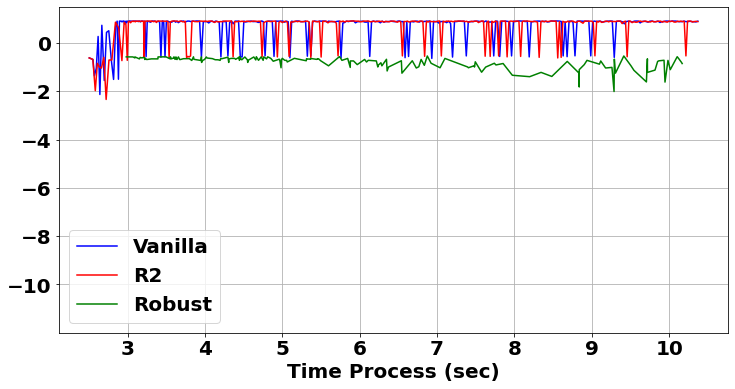

In [29]:
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20
window = 1

# vanilla_cp_rew_smooth = moving_average(vanilla_cp_rew.values, n=window)
# vanilla_cp_min_smooth = moving_average(vanilla_cp_min.values, n=window)
# vanilla_cp_max_smooth = moving_average(vanilla_cp_max.values, n=window)

# r2_cp_rew_smooth = moving_average(r2_cp_rew.values, n=window)
# r2_cp_min_smooth = moving_average(r2_cp_min.values, n=window)
# r2_cp_max_smooth = moving_average(r2_cp_max.values, n=window)

# robust_cp_rew_smooth = moving_average(robust_cp_rew.values, n=window)
# robust_cp_min_smooth = moving_average(robust_cp_min.values, n=window)
# robust_cp_max_smooth = moving_average(robust_cp_max.values, n=window)


ax.plot(vanilla_time_steps_, vanilla_cp_rew_not_nan_,'b', label='Vanilla') 
# ax.fill_between(vanilla_time_steps, vanilla_cp_min_not_nan, vanilla_cp_max_not_nan, alpha=0.15)

ax.plot(r2_time_steps_, r2_cp_rew_not_nan_,'r', label='R2') 
# ax.fill_between(r2_time_steps, r2_cp_min_not_nan, r2_cp_max_not_nan, alpha=0.15)

ax.plot(robust_time_steps_, robust_cp_rew_not_nan_,'g', label='Robust') 
# ax.fill_between(robust_time_steps, robust_cp_min_not_nan, robust_cp_max_not_nan, alpha=0.15)

# ax.plot(step, r2_cp_rew_smooth,'r', label='R2') 
# ax.fill_between(step, r2_cp_min_smooth, r2_cp_max_smooth, alpha=0.15)

# ax.plot(step, robust_cp_rew_smooth,'g', label='Robust')
# ax.fill_between(step, robust_cp_min_smooth, robust_cp_max_smooth, alpha=0.15)

# ax.set_title('Mars Rover Environment Reward', fontweight="bold", fontsize=fontsize)


# ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_xlabel('Time Process (sec)', fontsize=fontsize)
# ax.set_xlim(0,280)
# ax.invert_xaxis()

# ax.set_ylabel('Reward', fontsize=fontsize)
ax.set_yticks(range(-10,1,2))
ax.set_ylim(-12,1.5)
ax.tick_params(axis='both', labelsize=fontsize)
# plt.axvline(x=0.001, c='black')

ax.grid(True)
ax.legend(fontsize=fontsize, loc='best')

plt.savefig(os.path.abspath('wandbfixed_rover_convergence_time_zo_bigfont.png'))